<a href="https://colab.research.google.com/github/hexaquarks/PHYS339/blob/main/PHYS339_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Calibration

In [51]:
import numpy as np

SAMPLES = 3
callibrationInputs = list(range(0,260,10))
callibrationInputs.append(255)
callibrationInputs = callibrationInputs[5:-1]

callibrationOutputsA0 = [[] for y in range(SAMPLES)] 
callibrationOutputsA1 = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'CallibrationAnalogInputs_Lab3_Sample{i+1}.txt', "r") as stream:
          for line in stream:
              currLine = line[10:].split(",")
              callibrationOutputsA0[i].append(int(currLine[1]))
              callibrationOutputsA1[i].append(int(currLine[2]))

def standardization (arr):
  arr_out =  [np.mean([x,y,z]) for x,y,z in zip(*arr)]
  arr_out_error =  [np.std([x,y,z]) for x,y,z in zip(*arr)]                                                          
  return arr_out[5:-1],arr_out_error[5:-1]

callibrationOutputsA0, callibrationOutputsA0_error = standardization(callibrationOutputsA0)   
callibrationOutputsA1, callibrationOutputsA1_error = standardization(callibrationOutputsA1)   

### Fitting

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import linspace,polyfit, diag,sqrt
from numpy import log as ln
from scipy.optimize import curve_fit

def linearizedFit(x, y, y_error):
     popt, pcov = polyfit(
     x,
     y,
     1,
     w=[1 / (error+1) for error in y_error],
     cov=True,
     )
     perr = sqrt(diag(pcov))
     return popt, perr

def linearFitResiduals(x, x_error, m, m_error, b, b_error):
     y = m * x + b
     y_error = b_error + sqrt(
     (x * m_error) ** 2  + (m * x_error) ** 2)
     return y, y_error
 
def residual(x, x_error, y, y_error, m, m_error, b, b_error):
     y_fit, y_fit_error = linearFitResiduals(x, x_error, m, m_error, b, b_error)
     return y - y_fit, y_error + y_fit_error 
 
def chiSquared(ys, ys_error, fit_ys):
     return sum([
         ((y - fit_y) / y_error) ** 2
         for y, y_error, fit_y in zip(ys, ys_error, fit_ys)
     ])
 
def linearFit(x, m, b):
 return m*x + b

def linearFitError(x, m, m_error, b, b_error):
 return sqrt((x*m_error)**2 + b_error**2)

def  relativeDifference(x,y):
    return  (100 * np.abs(x-y)) / ((x + y) / 2) 

def  errorRelativeDifference(x,y,xs,ys):
    fx = 200 * (x**2 - (x-y)**2 -y**2) / ((x+y)**2 * np.abs(x-y))
    fy =  -200 * (x**2 - (x-y)**2 -y**2) / ((x+y)**2 * np.abs(x-y))
    return  np.sqrt((fx * xs)**2 +(fy * ys)**2)


In [53]:

## Callibration for 8 bit input from last Lab 
m_8bit = 0.01970
m_8bit_error = 0.00001
b_8bit = 0.003
b_8bit_error = 0.001

callibrationInputs = [linearFit(x,  m_8bit, b_8bit) for x in callibrationInputs ]
callibrationInputs_error = [
    linearFitError(x, m_8bit, m_8bit_error, b_8bit, b_8bit_error) for x in callibrationInputs ]

(m_A0, b_A0), \
(m_A0_error, b_A0_error)= \
linearizedFit(callibrationInputs, callibrationOutputsA0, callibrationOutputsA0_error)

(m_A1, b_A1), \
(m_A1_error, b_A1_error)= \
linearizedFit(callibrationInputs, callibrationOutputsA1, callibrationOutputsA1_error)

## Plotting

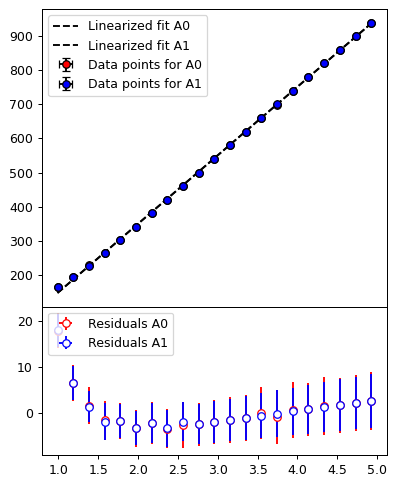

In [54]:
import matplotlib.pyplot as plt

fig, (a0, a1) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 1],
     "hspace": 0,
     },
     figsize=(4.5,5.5),
     dpi=90
)

fit_A0 = [linearFit(x, m_A0 , b_A0) for x in callibrationInputs]
fit_A1 = [linearFit(x, m_A1 , b_A1) for x in callibrationInputs]

a0.errorbar(
    x=callibrationInputs,
    y=callibrationOutputsA0,
    xerr = callibrationInputs_error,
    yerr = callibrationOutputsA0_error,
    fmt='ro', ecolor="black",mec="black", capsize=3,
    label = "Data points for A0")

a0.errorbar(
    x=callibrationInputs,
    y=callibrationOutputsA1,
    xerr = callibrationInputs_error,
    yerr = callibrationOutputsA1_error,
    fmt='bo', ecolor="black",mec="black", capsize=3,
    label = "Data points for A1")

a0.plot(
    callibrationInputs,
    fit_A0,
    '--',
    color='black',
    label="Linearized fit A0")

a0.plot(
    callibrationInputs,
    fit_A1,
    '--',
    color='black',
    label="Linearized fit A1")

#residual ploting
residuals_A0, residuals_A0_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_A0, m_A0_error, b_A0, b_A0_error)
             for x, x_error, y, y_error in zip(
                     callibrationInputs, callibrationInputs_error,
                     callibrationOutputsA0, callibrationOutputsA0_error
             )
     ])
]

residuals_A1, residuals_A1_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_A1, m_A1_error, b_A1, b_A1_error)
             for x, x_error, y, y_error in zip(
                     callibrationInputs, callibrationInputs_error,
                     callibrationOutputsA1, callibrationOutputsA1_error
             )
     ])
]

a1.errorbar(
     callibrationInputs,
     residuals_A0,
     xerr=callibrationInputs_error,
     yerr=residuals_A0_error,
     fmt="r.",
     marker="o",
     markerfacecolor="white",
     label="Residuals A0",
     color= "red"
)

a1.errorbar(
     callibrationInputs,
     residuals_A1,
     xerr=callibrationInputs_error,
     yerr=residuals_A1_error,
     fmt="b.",
     marker="o",
     markerfacecolor="white",
     label="Residuals A1",
     color= "blue"
)

for a in [a0, a1]:
    a.legend(loc="upper left")
fig.tight_layout()


### Converting the 10 bit outputs A0 and A1 given the found callibration parameters

In [55]:
callibrationOutputsA0 = [linearFit(x, m_A0, b_A0) for x in callibrationOutputsA0]
callibrationOutputsA0_error = [linearFitError(x, m_A0, m_A0_error, b_A0, b_A0_error) for x in callibrationOutputsA0]

callibrationOutputsA1 = [linearFit(x, m_A1, b_A1) for x in callibrationOutputsA1]
callibrationOutputsA1_error = [linearFitError(x, m_A1, m_A1_error, b_A1, b_A1_error) for x in callibrationOutputsA1]

In [56]:
def convertBitsToVolts(outputs, m, b):
  outputs_arr = [linearFit(x, m, b) for x in outputs]
  return outputs_arr

def convertBitsToVoltsError(outputs, m, m_error, b, b_error):
  outputs_arr = [np.sqrt((x*m_error)**2 + (b_error)**2) for x in outputs]
  return outputs_arr


## Color samples

### Opening file data


In [57]:
import numpy as np

m_10bit, m_10bit_error = 0.00491, 0.00001 #from last lab
b_10bit, b_10bit_error = 0.0486, 0.0007 #from last lab
m_8bit, m_8bit_error = 0.01970, 0.00003 #from last lab
b_8bit, b_8bit_error = 0.003, 0.001 #from last lab

FILE_NAMES = ["orange", "white", "warmWhite", "green", "red",
              "blue","ultraviolet"]
COLORS = len(FILE_NAMES)

colorInputs = list(range(0,255,10))[3:]
colorInputs.append(255)

## converting 8 bit input signal to volts then taking the log for semi-log scale
convertedInputs = convertBitsToVolts(colorInputs, m_8bit, b_8bit)
convertedInputsError = convertBitsToVoltsError(colorInputs, m_8bit,m_8bit_error, b_8bit, b_8bit_error)
logColorInputs = [np.log(x) for x in colorInputs]
logColorInputsError = [(x_error/ x) for x,x_error in zip(convertedInputs, convertedInputsError)]

## populating the A0 and A1 arrays from the files
colorOutputsA0 = [[] for x in range(COLORS)]
colorOutputsA1 = [[] for x in range(COLORS)]
                      
for i in range(COLORS):
  with open(f'{FILE_NAMES[i]}.txt', "r") as stream:
          for line in stream:
              currLine = line[10:].split(",")
              colorOutputsA0[i].append(float(currLine[1]))
              colorOutputsA1[i].append(float(currLine[2]))

## converting A0 and A1 to volts 
colorOutputsA0 = [convertBitsToVolts(colorOutputsA0[i][3:], m_10bit, b_10bit) for i in range(COLORS)]
colorOutputsA0_error = [convertBitsToVoltsError(
    colorOutputsA0[i], m_10bit, m_10bit_error, b_10bit, b_10bit_error
) for i in range(COLORS)]
colorOutputsA1 = [convertBitsToVolts(colorOutputsA1[i][3:], m_10bit, b_10bit) for i in range(COLORS)]
colorOutputsA1_error = [convertBitsToVoltsError(
    colorOutputsA1[i], m_10bit, m_10bit_error, b_10bit, b_10bit_error
) for i in range(COLORS)]

### Data treatment

In [58]:
R2, R2_error = 902, 1

def currentError(A0, A0_error, A1, A1_error):
  return np.sqrt((A0_error / R2)**2 + (A1_error / R2)**2 + ((A1- A0)/R2**2)**2)

#calculating current across LEDs
current_LED = [[(A0 - A1)/R2 for A0,A1 in zip(colorOutputsA0[i], colorOutputsA1[i])] 
         for i in range(COLORS)]
current_LED_error = [[currentError(A0, A0_error, A1, A1_error) for 
                      A0, A0_error, A1, A1_error 
                      in zip(colorOutputsA0[i], colorOutputsA0_error[i],
                             colorOutputsA1[i], colorOutputsA1_error[i])]
                     for i in range(COLORS)]

## converting A to mA
# current_LED = [ [x * 1000 for x in current_LED[i]] for i in range(COLORS)]    

current_LED = [ [np.exp(x * 1000) - 1 for x in current_LED[i]] for i in range(COLORS)]    
# current_LED_error = [ [1000* np.exp(x * 1000)*x_error for x,x_error 
#                        in zip(current_LED[i], current_LED_error[i])] for i in range(COLORS)]    
current_LED_error = [ [x * 1000 for x in current_LED_error[i]] for i in range(COLORS)]    
## Removing incoherent data points
for i  in range(COLORS):
  for j in range(len(current_LED[i])):
    if(current_LED[i][j] < 0): current_LED[i][j] = 0
    if(current_LED_error[i][j] < 0): current_LED_error[i][j] = 0


### Curve fittings

In [59]:
from scipy.optimize import curve_fit

#exponential fit
def exp(x, a, b):
    return a*(np.exp(x + b) - 1)

def least_squares_fit_parameters(
    inputs, 
    outputs, 
    outputs_error
):
    popt, pcov = curve_fit(
        exp, 
        inputs, 
        outputs, 
        sigma=outputs_error
    )
    perr = sqrt(diag(pcov))
    a, b= popt
    a_error , b_error = perr
    return a, a_error, b, b_error

In [60]:
from numpy import *
from scipy.optimize import leastsq

kb = 8.617332478e-5 # Boltzman's constant in eV

def fitLEDEquation(I,V,T,n,kb,Is,Rs):
  return Is * (np.exp((V - I*Rs) / (n*kb*T)) - 1)

def funcZero(args, T, V, I):
    I = np.array(I)
    n, Rs, Is = args
    return I * Rs + np.log((I/Is) + 1) * n * kb *T-V

def jacobian(args, T, V, I):
    I = np.array(I)
    n,Rs,Is = args
    
    kb = 8.617332478e-5
    res = zeros([3,len(V)])
    res[0,:] = log(I/Is+1)*kb*T
    res[1,:] = I
    res[2,:] = -I/(I*Is+Is**2)*n*kb*T
    return res

def parameters(V, I, T):
    return leastsq(funcZero, array([1,0,1e-14]),args=(T,V,I), Dfun=jacobian,
                   col_deriv=True,xtol=1e-15)[0]
                   

In [61]:
def nonlinearFitError(V, V_error, I, I_error,n, Kb, T, T_error, I0, R, R_error):
  return (I0 * np.exp((V - I*R)/(n * Kb * T))/ (n * Kb*T)) *\
          np.sqrt((V_error)**2 + (R * I_error)**2 + (I * R_error)**2)

def nonlinearFitResidualError(fit,fit_error, val, val_error):
  return np.sqrt((fit * val_error)**2 + (val * fit_error)**2)

def polynomialError(coeffs, x):
  return 3*x*coeffs[0]**2 + 2 * coeffs[1] * x + coeffs[2] * x

# Preprocessing lists by removing erroneous points
indexes = [10, 14, 15, 17, 20]
for index in sorted(indexes, reverse=True):
  del convertedInputs[index]
  del convertedInputsError[index]
  for j in range(COLORS):
    del current_LED[j][index] 
    del current_LED_error[j][index] 

current_LED = [current_LED[i][1:13] for i in range(len(current_LED))]
current_LED_error = [current_LED_error[i][1:13] for i in range(len(current_LED_error))]
convertedInputs = convertedInputs[1:13]
convertedInputsError = convertedInputsError[1:13]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
No handles with labels found to put in legend.


[0.005458301522246689, 0, 0.01646444635274391, 0.01646444635274369, 0, 0.07332892822391601, 0.11501647389971525, 0.22979986066914426, 0.41677246792797584, 0.7141244732263436, 0.8498616726330726, 0.9855100464497559]


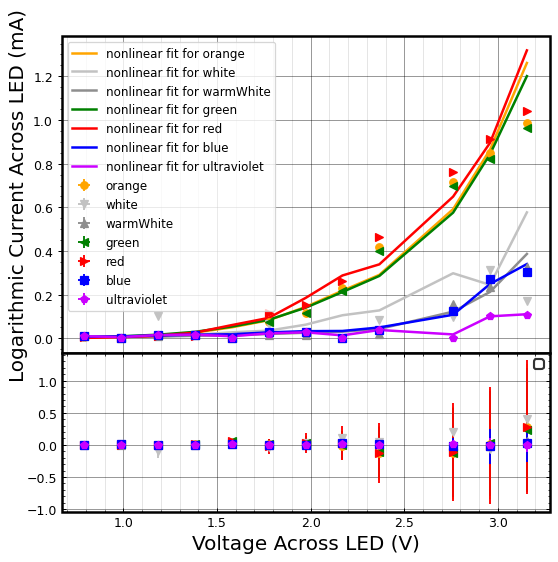

In [62]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy import linspace
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

FIGURE_COLORS = ["orange" , "#C2C2C2", "#8E8E8E", "green", "red", 
                "blue", "#CB00FF"]    
MARKER_SHAPE = ["o", "v", "^", "<", ">", "s", "p"]
turn_on_voltage = []
turn_on_voltage_error = []

fig, (ax, axs) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 1],
     "hspace": 0,
     },
     figsize=(7,7),
     dpi=90
)
print(current_LED[0])
for i in range(COLORS):
  ax.errorbar(
      x=convertedInputs,
      y=current_LED[i],
      xerr = convertedInputsError,
      yerr = current_LED_error[i],
      fmt=MARKER_SHAPE[i], color=FIGURE_COLORS[i], label=FILE_NAMES[i])
  
  ## curve fitting
  T,Rs,kb = 20+273.15 , 903, 8.617332478*10**(-5)
  T_error, R_error = 1, 1
  n, Rs, Is = parameters(convertedInputs, current_LED[i], T)

  fit_ys = [fitLEDEquation(I,V,T,n,kb,Is,Rs) 
         for I,V in zip(current_LED[i], convertedInputs)]
  fit_ys_error = [ 1 for x in range(len(current_LED[i]))]
  ax.plot(convertedInputs, fit_ys, color=FIGURE_COLORS[i], 
          linewidth=2, label=f'nonlinear fit for {FILE_NAMES[i]}')
  
  ## Residual plotting
  residuals = [fit - val for fit,val in zip(fit_ys, current_LED[i])]
  residuals_error = [ nonlinearFitResidualError(x, xs,y , ys) for 
                     x, xs, y, ys in zip(fit_ys, fit_ys_error, current_LED[i], current_LED_error[i])]

  axs.errorbar(
      x = convertedInputs,
      y = residuals,
      xerr = convertedInputsError,
      yerr = residuals_error,
      fmt=MARKER_SHAPE[i], color=FIGURE_COLORS[i]
  )

  ## computing the turn on voltage
  three_std = 3 * np.std(residuals)
  for j in range(len(current_LED[i])):
    if(fit_ys[j] >= three_std):
      diff = convertedInputs[j] - convertedInputs[j-1]
      turn_on_voltage.append(convertedInputs[j]- diff)
      turn_on_voltage_error.append((convertedInputs[j]) \
                                   / (2*(len(residuals)) - 2))
      break
  
  axs.set_xlabel('Voltage Across LED (V)', fontsize=16)
  ax.set_ylabel('Logarithmic Current Across LED (mA)', fontsize = 16)

ax.legend(loc="upper left", fontsize=9.5)

for ax in [ax, axs]:
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('2') 
  ax.grid(b=True, which='major', color='black', alpha=0.4, linestyle='-')
  ax.grid(b=True, which='minor', axis='x', color='black', linestyle='-', alpha=0.1)
  ax.minorticks_on()

## ticks 
ax.tick_params(axis='y',which='both',
               direction="in",right=True)
ax.tick_params(axis='x', which='both',
               direction="in", top=True,bottom=True)

## legend
legend = ax.legend()
legend.get_frame().set_linewidth(1.7)
legend.get_frame().set_edgecolor("black")
# plt.show()



## Boltzman Distributions

In [63]:
import numpy as np

FILE_NAMES = ["red", "pink", "orange", "green", "blue"]
FILE_NUMBERS = [1,2,3,6,7]
FILE_IDENTIFIERS = ["a" , "a 2", "b", "b 2"]
COLORS = len(FILE_NAMES)
IDENTIFIERS = len(FILE_IDENTIFIERS)

wavelengths = [[[] for x in range(4)] for y in range(COLORS)]
counts = [[[] for x in range(4)] for y in range(COLORS)]

for i in range(COLORS):
  for j in range(IDENTIFIERS):
    with open(
        f'./{FILE_NAMES[i]}{FILE_NUMBERS[i]}{FILE_IDENTIFIERS[j]}.csv', "r"
    ) as stream:
            for line in stream:
                currLine = line.split(",")
                wavelengths[i][j].append(float(currLine[0]))
                counts[i][j].append(float(currLine[1]))
                
def standardization (arr):
  arr_out =  [[np.mean([w,x,y,z]) for w,x,y,z in zip(*arr[k])] 
              for k in range(COLORS)]
  arr_out_error =  [[np.std([w,x,y,z]) for w,x,y,z in zip(*arr[k])] 
                    for k in range(COLORS)]                                                          
  return arr_out,arr_out_error

wavelengths, wavelengths_error = standardization(wavelengths)   
counts, counts_error = standardization(counts)   

## poisson error or standard deviation ? Need to ask TA
for i in range(COLORS):
  counts_error[i] = [np.sqrt(x) for x in counts[i]]


## Plotting the Boltzman distributions

In [64]:
from scipy.optimize import curve_fit

def gaussianFit(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

def least_squares_fit_parameters(
    inputs, 
    outputs, 
    outputs_error,
    mean
):
    popt, pcov = curve_fit(
        gaussianFit, 
        inputs, 
        outputs,
        p0 = [3700, mean, 30],
        sigma=outputs_error
    )
    perr = sqrt(diag(pcov))
    amp, mu, sig = popt
    amp_error, mu_error , sig_error = perr
    return amp, amp_error, mu, mu_error, sig, sig_error

In [65]:
wavelengths_sliced= [[] for x in range(COLORS)]
counts_sliced = [[] for x in range(COLORS)]
counts_error_sliced = [[] for x in range(COLORS)]
MEANS = [0 for x in range(COLORS)]
BOUNDS = [[15,17], [125,125], [18,20], [40,50], [26,30]]

for i in range(COLORS):
  max_value = np.max(counts[i])
  max_index = counts[i].index(max_value)
  MEANS[i] = wavelengths[i][max_index]
  wavelengths_sliced[i] = wavelengths[i][max_index-BOUNDS[i][0]:max_index+BOUNDS[i][1]]
  counts_sliced[i] = counts[i][max_index-BOUNDS[i][0]:max_index+BOUNDS[i][1]]
  counts_error_sliced[i] = counts_error[i][max_index-BOUNDS[i][0]:max_index+BOUNDS[i][1]]

In [66]:
fit_amplitudes, fit_means, fit_sigmas = ([[0,0] for x in range(COLORS)] for i in range(3))
for i in range(COLORS):
  fit_amplitudes[i][0], fit_amplitudes[i][1],\
  fit_means[i][0], fit_means[i][1], \
  fit_sigmas[i][0], fit_sigmas[i][1] = \
  least_squares_fit_parameters(wavelengths_sliced[i] , counts_sliced[i], counts_error_sliced[i] ,MEANS[i])


0.02384967744115411
0.041359306733864024
0.02296257688293756
0.03774413181186633
0.028774320222978374


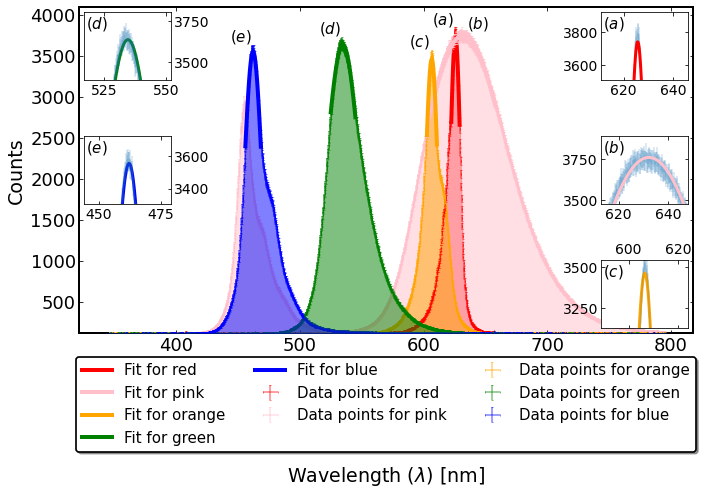

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

fig, ax = plt.subplots(figsize=[11,6])

COLOR_IDENTIFIERS = ["red", "pink", "orange", "green", "blue"]
LABELS = ["Data points for red", "Data points for pink",
          "Data points for orange", "Data points for green",
          "Data points for blue"]
LABELS_FIT = ["Fit for red", "Fit for pink",
          "Fit for orange", "Fit for green",
          "Fit for blue"]    
INSET_LOCATORS = ["upper right", "center right", "lower right", 
                  "upper left", "center left"]
INSET_LABELS = [r"$(a)$", r"$(b)$",r"$(c)$",r"$(d)$",r"$(e)$"] 
wavelengths_peak = []     
dx = 35
dy= 416
inset_bounds = [[611, 611+dx, 3507, 3507+dy], [613,613+dx,3476,3476+dy],
                [589, 589+dx, 3126, 3126+dy], [517, 517+dx, 3391, 3391+dy],
                [444, 444+dx, 3306, 3306+dy]]

for i in range(COLORS):
  ## plotting the main error bars
  ax.errorbar(
      x=wavelengths[i],
      y=counts[i],
      xerr = wavelengths_error[i],
      yerr = counts_error[i],
      color=COLOR_IDENTIFIERS[i],
      fmt='', ls='none',
      label = LABELS[i], ecolor=COLOR_IDENTIFIERS[i], capsize=1,
      alpha=0.5)
  
  ## plotting the fit lines
  fit_y = [gaussianFit(x, fit_amplitudes[i][0], fit_means[i][0] , fit_sigmas[i][0]) 
      for x in wavelengths_sliced[i]]
  ax.plot(wavelengths_sliced[i], fit_y, 
           color=COLOR_IDENTIFIERS[i], label=LABELS_FIT[i],
           linewidth=4)
  ax.fill_between(wavelengths[i], counts[i][0], 
                  counts[i], color=COLOR_IDENTIFIERS[i], alpha=0.5, zorder=i)

  ## finding the peak wavelengths
  print(fit_means[i][1])

  ## plotting the zoomin sets 
  axins = zoomed_inset_axes(ax,2,loc=INSET_LOCATORS[i])
  axins.errorbar(
      x=wavelengths[i],
      y=counts[i],
      xerr = wavelengths_error[i],
      yerr = counts_error[i],
      alpha=0.2, zorder=i)

  axins.plot(wavelengths_sliced[i], fit_y, 
            color=COLOR_IDENTIFIERS[i], label=LABELS_FIT[i],
            linewidth=3)

  x1,x2,y1,y2 =\
  inset_bounds[i][0], inset_bounds[i][1],inset_bounds[i][2], inset_bounds[i][3]

  axins.set_xlim(x1,x2)
  axins.set_ylim(y1,y2)
  mark_inset(ax,axins,loc1=1,loc2=3, linewidth=0)
  axins.yaxis.tick_right()
  if(i == 2):
    ## for the orange zoom inset
    axins.xaxis.tick_top()
  if(i == 0 or i == 1 or i == 2):
    axins.yaxis.tick_left()

  ## plot annotations 
  if(i == 1):
    #pink
    ax.text(MEANS[i]+13, np.max(counts[i])+100, f'{INSET_LABELS[i]}', horizontalalignment='center', 
          verticalalignment='center', fontsize=15)
  else:
    ax.text(MEANS[i]-10, np.max(counts[i])+150, f'{INSET_LABELS[i]}', horizontalalignment='center', 
          verticalalignment='center', fontsize=15)
    
  ## zoomed insets annotations 
  axins.text(x1+5, y2-75, f'{INSET_LABELS[i]}', horizontalalignment='center', 
          verticalalignment='center', fontsize=15)
  
  ## zoom inset tick parameters
  axins.tick_params(axis='y',
               direction="in",
               right=True, labelsize=14)
  axins.tick_params(axis='x', direction="in" , top=True,bottom=True, labelsize=14)
  axins.xaxis.get_major_locator().set_params(nbins=1)

  # ## zoom inset border color
  # legend_axin = axins.get_legend()
  # legend_axin.get_frame().set_linewidth(1.7)
  # legend_axin.get_frame().set_edgecolor("black")
    
## ticks 
ax.tick_params(axis='y',
               direction="in",
               right=True, labelsize=18)
ax.tick_params(axis='x', direction="in" , top=True,bottom=True, labelsize=18)

## legends and utilities
ax.set_xlabel(r"Wavelength $(\lambda)$ [nm]", fontsize=19, labelpad=110)
ax.set_ylabel("Counts", fontsize=19)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=3, fancybox=True, shadow=True, fontsize=15)
ax.set_ylim((120,4100))

## border colors
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2') 
legend = ax.get_legend()
legend.get_frame().set_linewidth(1.7)
legend.get_frame().set_edgecolor("black")

plt.show()

### Finding $\hbar$ 



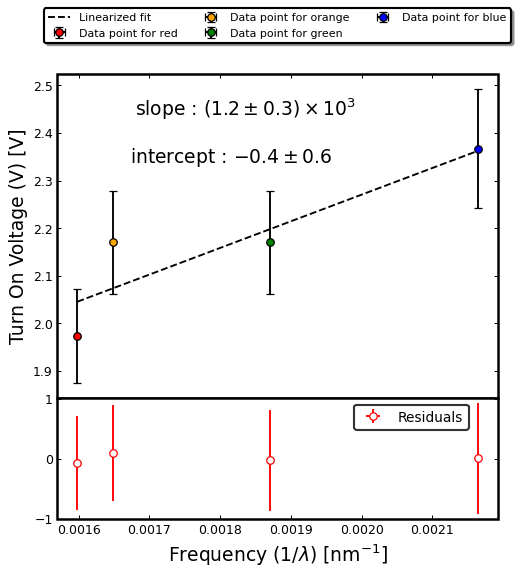

In [68]:
import matplotlib.pyplot as plt

# FILE_NAMES = ["orange", "white", "warmWhite", "green", "red",
#               "blue","ultraviolet"] # turn on
COLOR_IDENTIFIERS = ["red","orange", "green", "blue"] # boltzman

wavelengths_peak , wavelengths_peak_error =\
[1 / fit_means[i][0] for i in range(COLORS)] ,[(-1 / fit_means[i][0]**2)*fit_means[i][1] for i in range(COLORS)]
del wavelengths_peak[1]
del wavelengths_peak_error[1]
indexes = [4, 0, 3, 5]
turn_on_voltage_sliced = [turn_on_voltage[i] for i in indexes]
turn_on_voltage_sliced_error = [turn_on_voltage_error[i] for i in indexes]

(m_h, b_h), \
(m_h_error, b_h_error)= \
linearizedFit(wavelengths_peak, turn_on_voltage_sliced, turn_on_voltage_sliced_error)

fit_h = [linearFit(x,m_h,b_h) for x in wavelengths_peak]

fig, (a0, a1) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 0.75],
     "hspace": 0,
     },
     figsize=(6,6.5),
     dpi=90
)
for i in range(len(COLOR_IDENTIFIERS)):
  a0.errorbar(
      x=wavelengths_peak[i],
      y=turn_on_voltage_sliced[i],
      xerr = wavelengths_peak_error[i],
      yerr = turn_on_voltage_sliced_error[i],
      fmt='o',color=COLOR_IDENTIFIERS[i], ecolor="black",mec="black", capsize=3,
      label = f"Data point for {COLOR_IDENTIFIERS[i]}")

a0.plot(
    wavelengths_peak,
    fit_h,
    '--',
    color='black',
    label="Linearized fit")

#residual ploting
residuals_h, residuals_h_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_h, m_h_error, b_h, b_h_error)
             for x, x_error, y, y_error in zip(
                     wavelengths_peak, wavelengths_peak_error,
                     turn_on_voltage_sliced, turn_on_voltage_sliced_error
             )
     ])
]

a1.errorbar(
     wavelengths_peak,
     residuals_h,
     xerr=wavelengths_peak_error,
     yerr=residuals_h_error,
     fmt="r.",
     marker="o",
     markerfacecolor="white",
     label="Residuals",
     color= "black"
)

a0.text (0.001836, 2.45, r'slope : $(1.2 \pm 0.3) \times 10^{3}$', horizontalalignment='center',
         verticalalignment='center', fontsize =15)
a0.text (0.001815, 2.35, r'intercept : $-0.4 \pm 0.6$', horizontalalignment='center',
         verticalalignment='center', fontsize =15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
          ncol=3, fancybox=True, shadow=True, fontsize=8.75)
a1.legend(loc='upper right', bbox_to_anchor=(0.95, 1), fontsize=11)

for a in [a0, a1]:
    a.patch.set_edgecolor('black')  
    a.patch.set_linewidth('2') 
    legend = a.get_legend()
    legend.get_frame().set_linewidth(1.7)
    legend.get_frame().set_edgecolor("black")
## ticks 
a0.tick_params(axis='y',
               direction="in",
               right=True)
a0.tick_params(axis='x', direction="in" , top=True,bottom=False)
a1.tick_params(axis='y',
               direction="in",
               right=True)
a1.tick_params(axis='x', direction="in" , top=False,bottom=True)

## legends and utilities
a1.set_xlabel(r"Frequency $(1/\lambda)$ [nm$^{-1}$]", fontsize=15)
a0.set_ylabel("Turn On Voltage (V) [V]", fontsize=15)

fig.tight_layout()

### Computing $\hbar$

In [70]:
e,e_error = 1.60217648* 10**(-19), 0.00000007* 10**(-19)
c = 299792458

h = ((m_h * e) / c)
h_error = (1/c) * np.sqrt((e*m_h_error)**2 + (m_h * e_error)**2)
print(h)
print(h_error)

2.9935054121663274e-25
1.0586684156041293e-25
